<a href="https://colab.research.google.com/github/yequalsmxplusc/project/blob/main/CHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymoo pyswarm openpyxl

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.4 MB/s eta 0:00:00
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=ce4e2b90da6404af6c2c56b22d2befff44308b45d6e7e6b11dfb34c047b8b92c
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=761892b7b8f8be72909a79392523baa3a9207db3a9cc437ff978a5ccc6c7e864
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Suc

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    # First normalize the data to get normalization statistics
    X_train_norm, X_test_norm, y_train_norm, y_test_norm, norm_stats = normalize(X_train, X_test, y_train, y_test)

    def augment_data(X, y, norm_stats, noise_factor=0.01, temp_threshold=70):
        """Enhanced data augmentation with temperature-based oversampling"""
        # Denormalize y to actual temperatures using provided norm_stats
        y_actual = y * norm_stats[3] + norm_stats[2]

        # Add standard noise
        X_noisy = X + noise_factor * np.random.randn(*X.shape)
        y_noisy = y.copy()

        # Oversample high-temperature cases
        high_temp_idx = np.where(y_actual > temp_threshold)[0]
        if len(high_temp_idx) > 0:
            X_high = X[high_temp_idx]
            y_high = y[high_temp_idx]

            # Create extra noisy versions of high-temp samples
            for _ in range(3):  # 3x oversampling
                X_high_noisy = X_high + (noise_factor*2) * np.random.randn(*X_high.shape)
                X_noisy = np.vstack([X_noisy, X_high_noisy])
                y_noisy = np.vstack([y_noisy, y_high])

        return np.vstack([X, X_noisy]), np.vstack([y, y_noisy])

    # Augment the normalized data
    X_train_aug, y_train_aug = augment_data(X_train_norm, y_train_norm, norm_stats)

    return X_train_aug, X_test_norm, y_train_aug, y_test_norm, norm_stats


# Load and preprocess data for aspect ratio 0.3
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

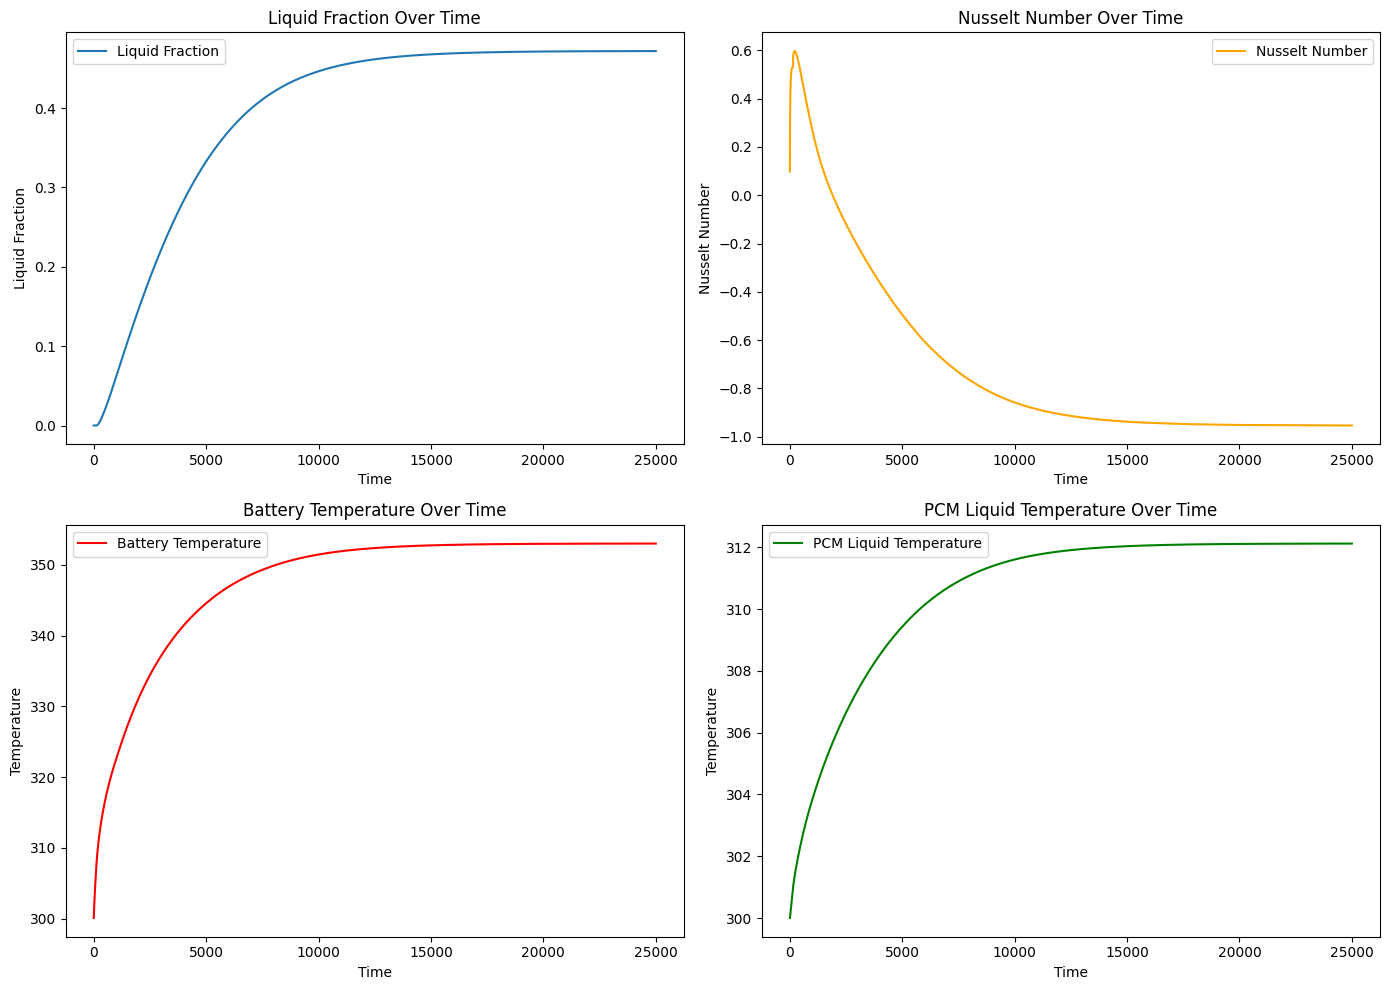

In [3]:
import matplotlib.pyplot as plt

# Load your data from an Excel file
df = pd.read_excel('/content/0.3.xlsx')  # Replace 'your_data_file.xlsx' with the path to your actual data file

# Sort data by time
df = df.sort_values('time')

# Plotting the data
plt.figure(figsize=(14, 10))

# Plot Liquid Fraction
plt.subplot(2, 2, 1)
plt.plot(df['time'], df['liquid_frac'], label='Liquid Fraction')
plt.xlabel('Time')
plt.ylabel('Liquid Fraction')
plt.title('Liquid Fraction Over Time')
plt.legend()

# Plot Nusselt Number
plt.subplot(2, 2, 2)
plt.plot(df['time'], df['Nu'], label='Nusselt Number', color='orange')
plt.xlabel('Time')
plt.ylabel('Nusselt Number')
plt.title('Nusselt Number Over Time')
plt.legend()

# Plot Battery Temperature
plt.subplot(2, 2, 3)
plt.plot(df['time'], df['T_battery'], label='Battery Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Battery Temperature Over Time')
plt.legend()

# Plot PCM Liquid Temperature
plt.subplot(2, 2, 4)
plt.plot(df['time'], df['T_pcm'], label='PCM Liquid Temperature', color='green')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('PCM Liquid Temperature Over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso

# Define the LSTM model
class SimplePINN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimplePINN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predict temperature

    def forward(self, x):
        # Ensure the input tensor has the correct shape
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension if it's missing
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)

# Load and preprocess data
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    data = pd.read_excel(data_path)
    data = data.sort_values('time')
    data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
    data = data.dropna()

    split_idx = int(len(data) * (1 - test_ratio))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]

    def create_sequences(df):
        sequences, targets = [], []
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']
        for i in range(len(df) - seq_length):
            seq = df.iloc[i:i+seq_length]
            sequences.append(seq[features].values)
            targets.append(seq[target_col].iloc[-1].values)
        return np.array(sequences), np.array(targets)

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    def normalize(X_train, X_test, y_train, y_test):
        X_mean, X_std = X_train.mean(axis=(0, 1)), X_train.std(axis=(0, 1))
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)
        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)
        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Load and preprocess data
X_train, X_test, y_train, y_test, norm_stats = load_and_preprocess_data('/content/0.3.xlsx')

# Define the optimization problem
class BatteryCoolingProblem(Problem):
    def __init__(self, model, X_train, y_train):
        super().__init__(n_var=3, n_obj=2, n_constr=1, xl=np.array([0.1, 1000, 0.1]), xu=np.array([0.9, 2000, 0.9]))
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 3)
        liquid_frac, Nu, T_pcm = x[:, 0], x[:, 1], x[:, 2]

        temps = 50 - 15*0.3 + 0.5*np.sin(10*0.3) + 0.1*liquid_frac - 0.05*Nu + 0.01*T_pcm
        safety_margins = 5 + 20*0.3 - 2*np.cos(8*0.3) - 0.2*liquid_frac + 0.1*Nu - 0.05*T_pcm
        vortex_constraint = 0.3 - (0.35 + 0.05*np.sin(5*0.3)) + 0.01*liquid_frac - 0.005*Nu + 0.001*T_pcm

        out["F"] = np.column_stack([temps, -safety_margins])
        out["G"] = vortex_constraint

# Initialize the model
model = SimplePINN(input_size=4)

# Example usage of the optimization problem
problem = BatteryCoolingProblem(model, torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
algorithm = NSGA2(pop_size=30, n_offsprings=15, eliminate_duplicates=True)
res = minimize(problem, algorithm, ('n_gen', 75), seed=42, verbose=True)

# Define the objective function for PSO
def objective_function(x):
    return np.sum(x**2)  # Replace with your actual objective function

# Run PSO to get optimized parameters
lb = [0.1, 1000, 0.1]
ub = [0.9, 2000, 0.9]
x_opt, _ = pso(objective_function, lb, ub, swarmsize=20, maxiter=50)

# Example: Modify dataset based on optimization results
optimized_params = np.append(x_opt, 300.0)  # Assuming T_pcm is the fourth parameter
optimized_data = pd.DataFrame({
    'aspect_ratio': optimized_params[0],
    'liquid_frac': optimized_params[1],
    'Nu': optimized_params[2],
    'T_pcm': optimized_params[3],
    'T_battery': model(torch.tensor(optimized_params[:4], dtype=torch.float32).unsqueeze(0)).item()
}, index=[0])

# Save the optimized dataset
optimized_data.to_csv('optimized_data.csv', index=False)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       30 |      1 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |       45 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.000000E+00 |  0.000000E+00 |  2.3208224393 |         ideal
     4 |       75 |      1 |  0.000000E+00 |  0.000000E+00 |  0.3633220635 |         ideal
     5 |       90 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      105 |      1 |  0.000000E+00 |  0.000000E+00 |  0.7234067849 |         ideal
     7 |      120 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      135 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0525466186 |         ideal
     9 |      150 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |      165 |      1 |  0.000000E+00 |  0.000000E+00 |  0.0210259233 |         ideal

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from collections import defaultdict

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # Add batch dimension

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

class UltraCoolingModel(nn.Module):
    def __init__(self, input_size, seq_length=10):
        super().__init__()
        self.seq_length = seq_length

        # Feature embedding
        self.embed = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Linear(128, 64)
        )
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model=64, max_len=seq_length)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=256,
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # LSTM temporal processor
        self.lstm = nn.LSTM(64, 96, num_layers=1, batch_first=True)

        # Attention mechanisms
        self.coarse_attention = nn.Linear(96, 1)
        self.feature_attention = nn.Linear(96, 96)

        # Prediction heads
        self.temp_head = nn.Linear(96, 2)
        self.correction_head = nn.Sequential(
            nn.Linear(96, 64),
            nn.SiLU(),
            nn.Linear(64, 1)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # Input shape: (batch, seq_len, features)
        x = self.embed(x)

        # Transformer processing
        x = self.pos_encoder(x)
        x = self.transformer(x)

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Hierarchical attention
        coarse_attn = torch.softmax(self.coarse_attention(lstm_out), dim=1)
        context = (coarse_attn * lstm_out).sum(dim=1)
        feature_weights = torch.sigmoid(self.feature_attention(context))
        context = context * feature_weights

        # Dual prediction
        mean, log_var = self.temp_head(context).chunk(2, dim=-1)
        correction = self.correction_head(context)

        # Temperature-dependent correction
        return mean + torch.sigmoid(mean/20) * correction, log_var.exp()

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UltraCoolingModel(input_size=4, seq_length=X_train.shape[1]).to(device)  # Use actual sequence length

# Custom loss
class HybridLoss(nn.Module):
    def __init__(self, norm_stats):
        super().__init__()
        self.y_std = norm_stats[3]

    def forward(self, pred_mean, pred_var, target):
        precision = 1/pred_var.clamp(min=1e-6)
        loss = (precision * (pred_mean - target)**2 + pred_var.log()).mean()
        weights = torch.where(target > 0.5, 1.5, 1.0)
        return (weights * loss).mean()

# Training setup
criterion = HybridLoss(norm_stats)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    ),
    batch_size=64, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_test[:2000], dtype=torch.float32),
        torch.tensor(y_test[:2000], dtype=torch.float32)
    ),
    batch_size=128
)

# Training loop
for epoch in range(150):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        pred_mean, pred_var = model(batch_X)
        loss = criterion(pred_mean, pred_var, batch_y)

        # Hard example mining - FIXED INDEXING
        with torch.no_grad():
            errors = torch.abs(pred_mean - batch_y)
            hard_mask = errors > errors.quantile(0.9)
            if hard_mask.any():
                # Squeeze the mask to match batch dimension
                hard_mask = hard_mask.squeeze()
                # Ensure we're selecting whole sequences, not individual elements
                hard_loss = F.smooth_l1_loss(
                    model(batch_X[hard_mask])[0],  # Selects whole sequences where mask is True
                    batch_y[hard_mask],
                    beta=0.5)
                loss += 0.3 * hard_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

In [8]:
def evaluate_model(model, X_test, y_test, norm_stats):
    model.eval()
    device = next(model.parameters()).device
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_mean, pred_var = model(X_tensor)

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_actual = y_test * y_std + y_mean
    pred_actual = pred_mean.cpu().numpy() * y_std + y_mean
    uncertainty = torch.sqrt(pred_var).cpu().numpy() * y_std

    # Metrics
    metrics = {
        'mae': mean_absolute_error(y_actual, pred_actual),
        'rmse': np.sqrt(mean_squared_error(y_actual, pred_actual)),
        'r2': r2_score(y_actual, pred_actual),
        'max_error': np.max(np.abs(y_actual - pred_actual)),
        'avg_uncertainty': np.mean(uncertainty)
    }

    # Visualization
    plt.figure(figsize=(18, 6))

    # Plot 1: Actual vs Predicted
    plt.subplot(1, 3, 1)
    plt.scatter(y_actual, pred_actual, c=np.abs(y_actual - pred_actual),
                cmap='viridis', alpha=0.6, vmin=0, vmax=20)
    plt.colorbar(label='Absolute Error (°C)')
    plt.plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()], 'r--')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title('Prediction Accuracy')

    # Plot 2: Error distribution
    plt.subplot(1, 3, 2)
    errors = y_actual - pred_actual
    plt.hist(errors, bins=30, density=True)
    plt.xlabel('Prediction Error (°C)')
    plt.title(f'Error Distribution\n(σ={np.std(errors):.2f}°C)')

    # Plot 3: Uncertainty calibration
    plt.subplot(1, 3, 3)
    bins = np.linspace(0, 20, 10)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_errors = []
    bin_uncertainties = []
    for i in range(len(bins)-1):
        mask = (uncertainty >= bins[i]) & (uncertainty < bins[i+1])
        if mask.any():
            bin_errors.append(np.mean(np.abs(errors[mask])))
            bin_uncertainties.append(np.mean(uncertainty[mask]))
    plt.plot(bin_uncertainties, bin_errors, 'bo-')
    plt.plot([0, 20], [0, 20], 'r--')
    plt.xlabel('Predicted Uncertainty (°C)')
    plt.ylabel('Actual MAE (°C)')
    plt.title('Uncertainty Calibration')
    plt.tight_layout()
    plt.show()

    return metrics

In [9]:
def analyze_temperature_bins(model, X_test, y_test, norm_stats):
    model.eval()
    device = next(model.parameters()).device
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    bins = {
        'Low (<70°C)': {'errors': [], 'uncertainties': [], 'samples': 0},
        'Medium (70-100°C)': {'errors': [], 'uncertainties': [], 'samples': 0},
        'High (>100°C)': {'errors': [], 'uncertainties': [], 'samples': 0}
    }

    with torch.no_grad():
        pred_mean, pred_var = model(X_tensor)
        pred_mean = pred_mean.cpu().numpy() * norm_stats[3] + norm_stats[2]
        pred_std = np.sqrt(pred_var.cpu().numpy()) * norm_stats[3]
        y_actual = y_test * norm_stats[3] + norm_stats[2]

        for i in range(len(y_actual)):
            temp = y_actual[i][0]
            error = abs(pred_mean[i][0] - temp)

            if temp < 70:
                bin_key = 'Low (<70°C)'
            elif temp < 100:
                bin_key = 'Medium (70-100°C)'
            else:
                bin_key = 'High (>100°C)'

            bins[bin_key]['errors'].append(error)
            bins[bin_key]['uncertainties'].append(pred_std[i][0])
            bins[bin_key]['samples'] += 1

    print("Temperature Range Performance Analysis:")
    for name, data in bins.items():
        if data['samples'] > 0:
            print(f"\n{name}:")
            print(f"  Samples: {data['samples']}")
            print(f"  MAE: {np.mean(data['errors']):.2f} ± {np.std(data['errors']):.2f}°C")
            print(f"  Max Error: {np.max(data['errors']):.2f}°C")
            print(f"  Avg Uncertainty: {np.mean(data['uncertainties']):.2f}°C")
            print(f"  Calibration Ratio: {np.mean(data['errors'])/np.mean(data['uncertainties']):.2f}")

In [10]:
def analyze_worst_predictions(model, X_test, y_test, norm_stats, n=10):
    model.eval()
    device = next(model.parameters()).device
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_mean, pred_var = model(X_tensor)
        pred_mean = pred_mean.cpu().numpy() * norm_stats[3] + norm_stats[2]
        pred_std = np.sqrt(pred_var.cpu().numpy()) * norm_stats[3]
        y_actual = y_test * norm_stats[3] + norm_stats[2]

        errors = np.abs(pred_mean - y_actual)
        worst_indices = np.argsort(errors.squeeze())[-n:][::-1]

    print("\nWorst Predictions Analysis:")
    print(f"{'Index':<8}{'Actual':<10}{'Predicted':<12}{'Error':<10}{'Uncertainty':<12}")
    for idx in worst_indices:
        print(f"{idx:<8}{y_actual[idx][0]:<10.2f}{pred_mean[idx][0]:<12.2f}"
              f"{errors[idx][0]:<10.2f}{pred_std[idx][0]:<12.2f}")

    # Plot feature patterns
    plt.figure(figsize=(12, 6))
    for i, feat in enumerate(['Aspect Ratio', 'Liquid Fraction', 'Nu', 'T_pcm']):
        plt.subplot(2, 2, i+1)
        for idx in worst_indices[:5]:
            plt.plot(X_test[idx, :, i], label=f'Err={errors[idx][0]:.1f}°C')
        plt.title(feat)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.show()

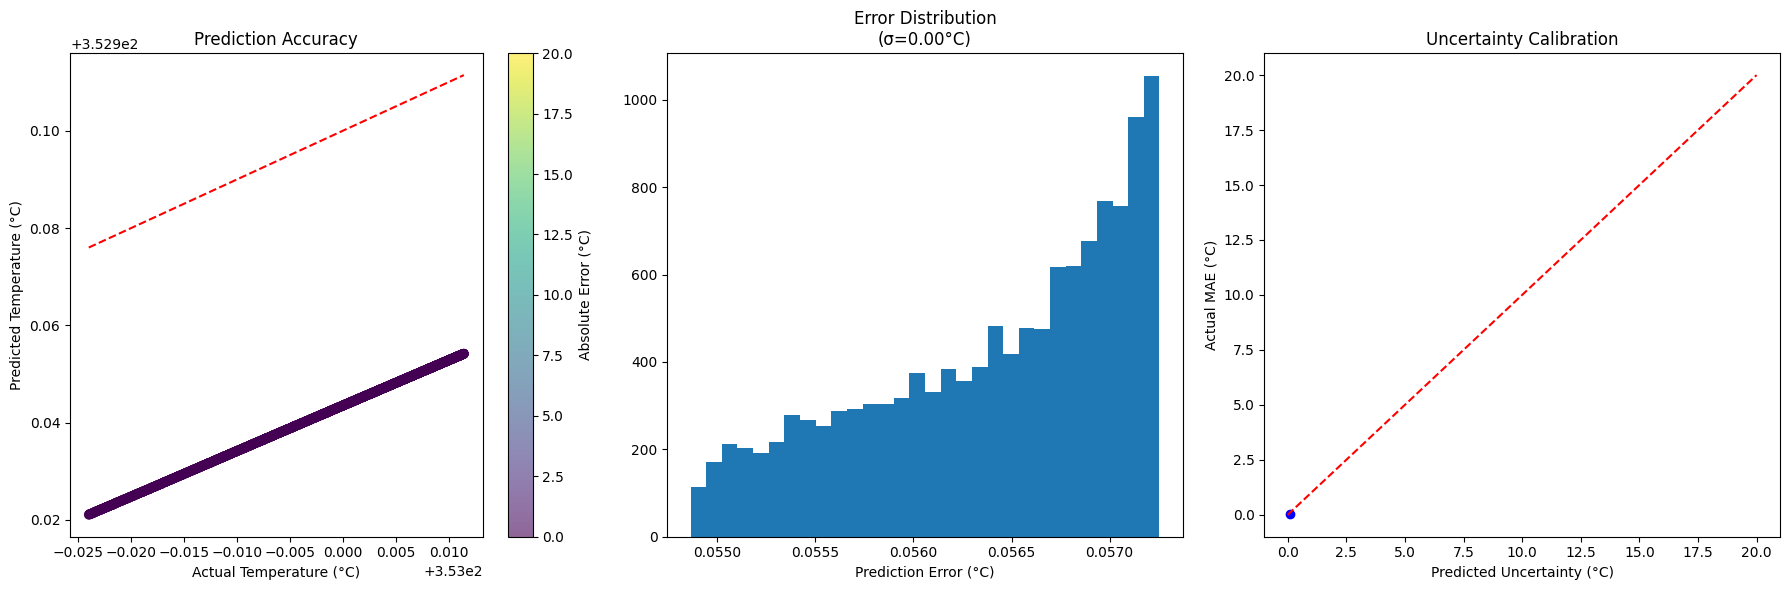

Temperature Range Performance Analysis:

High (>100°C):
  Samples: 4990
  MAE: 0.06 ± 0.00°C
  Max Error: 0.06°C
  Avg Uncertainty: 0.08°C
  Calibration Ratio: 0.71

Worst Predictions Analysis:
Index   Actual    Predicted   Error     Uncertainty 
4983    353.01    352.95      0.06      0.08        
4987    353.01    352.95      0.06      0.08        
4989    353.01    352.95      0.06      0.08        
4982    353.01    352.95      0.06      0.08        
4986    353.01    352.95      0.06      0.08        
4985    353.01    352.95      0.06      0.08        
4979    353.01    352.95      0.06      0.08        
4988    353.01    352.95      0.06      0.08        
4981    353.01    352.95      0.06      0.08        
4980    353.01    352.95      0.06      0.08        


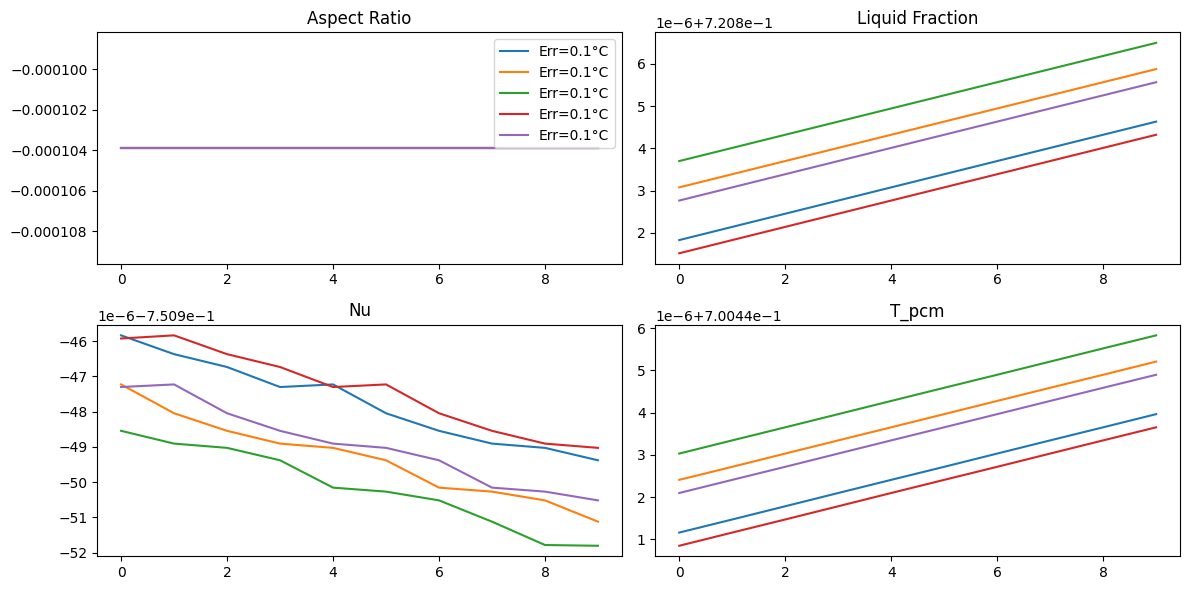

In [11]:
# After training
metrics = evaluate_model(model, X_test, y_test, norm_stats)
analyze_temperature_bins(model, X_test, y_test, norm_stats)
analyze_worst_predictions(model, X_test, y_test, norm_stats)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TemperatureWeightedMSELoss(nn.Module):
#     def __init__(self, norm_stats, threshold=70.0, weight_factor=5.0):
#         super().__init__()
#         # Convert normalization stats to tensors
#         self.register_buffer('y_mean', torch.tensor(norm_stats[2], dtype=torch.float32))
#         self.register_buffer('y_std', torch.tensor(norm_stats[3], dtype=torch.float32))
#         self.threshold = threshold
#         self.weight_factor = weight_factor

#     def forward(self, pred, target):
#         # Denormalize predictions and targets (keeping tensors)
#         pred_actual = pred * self.y_std + self.y_mean
#         target_actual = target * self.y_std + self.y_mean

#         # Calculate base MSE
#         base_loss = F.mse_loss(pred, target)

#         # Calculate weights based on temperature
#         weights = torch.ones_like(target_actual)
#         above_threshold = target_actual > self.threshold
#         weights[above_threshold] = self.weight_factor

#         # Apply weighted loss
#         weighted_loss = (weights * (pred - target)**2).mean()

#         return 0.7*weighted_loss + 0.3*base_loss  # Combined loss

# class EnhancedPINN(nn.Module):
#     def __init__(self, input_size, hidden_size=128):
#         super(EnhancedPINN, self).__init__()

#         # Main LSTM branch
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=2,
#             batch_first=True,
#             dropout=0.2
#         )

#         # Auxiliary high-temperature branch
#         self.high_temp_branch = nn.Sequential(
#             nn.Linear(input_size*10, 64),  # Flattened sequence
#             nn.ReLU(),
#             nn.Linear(64, 32)
#         )

#         # Combined prediction
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size+32, 64),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         # Ensure correct input dimensions
#         if x.dim() == 2:
#             x = x.unsqueeze(0)

#         # Main LSTM processing
#         lstm_out, _ = self.lstm(x)
#         lstm_last = lstm_out[:, -1, :]

#         # High-temperature auxiliary branch
#         flat_seq = x.reshape(x.shape[0], -1)  # Flatten sequence
#         aux_out = self.high_temp_branch(flat_seq)

#         # Combined prediction
#         combined = torch.cat([lstm_last, aux_out], dim=1)
#         return self.fc(combined)

# # Initialize model
# model = EnhancedPINN(input_size=4)  # 4 input features

# # Training parameters - using our custom loss
# criterion = TemperatureWeightedMSELoss(norm_stats, threshold=70.0, weight_factor=5.0)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
# epochs = 100
# batch_size = 32

# # Data preparation
# train_dataset = torch.utils.data.TensorDataset(
#     torch.tensor(X_train, dtype=torch.float32),
#     torch.tensor(y_train, dtype=torch.float32)
# )
# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     shuffle=True
# )

# # Validation subset (first 1000 samples)
# X_val = torch.tensor(X_test[:1000], dtype=torch.float32)
# y_val = torch.tensor(y_test[:1000], dtype=torch.float32)

# # Training loop
# print("Starting training...")
# for epoch in range(epochs):
#     model.train()
#     running_loss = 0.0

#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
#         optimizer.step()
#         running_loss += loss.item()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val)
#         val_loss = criterion(val_outputs, y_val)
#     scheduler.step(val_loss)

#     # Print statistics
#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}')

# print("Training completed!")

Starting training...
Epoch [10/100], Train Loss: 0.0177, Val Loss: 0.0002
Epoch [20/100], Train Loss: 0.0168, Val Loss: 0.0001
Epoch [30/100], Train Loss: 0.0164, Val Loss: 0.0003
Epoch [40/100], Train Loss: 0.0154, Val Loss: 0.0002
Epoch [50/100], Train Loss: 0.0153, Val Loss: 0.0000
Epoch [60/100], Train Loss: 0.0158, Val Loss: 0.0000
Epoch [70/100], Train Loss: 0.0154, Val Loss: 0.0000
Epoch [80/100], Train Loss: 0.0152, Val Loss: 0.0000
Epoch [90/100], Train Loss: 0.0150, Val Loss: 0.0000
Epoch [100/100], Train Loss: 0.0153, Val Loss: 0.0000
Training completed!


In [12]:
def load_data(data_path):
    """Load data file (CSV or Excel) without time-series processing"""
    if data_path.endswith('.csv'):
        return pd.read_csv(data_path, encoding='latin1')
    else:
        return pd.read_excel(data_path, engine='openpyxl')

def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Handle both time-series and optimization result files"""
    data = load_data(data_path)

    # CASE 1: Time-series data (has 'time' column)
    if 'time' in data.columns:
        data = data.sort_values('time')
        if 'liquid_frac' in data.columns:
            data['liquid_frac_rolling'] = data['liquid_frac'].rolling(window=5).mean()
        data = data.dropna()

        # Train-test split
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # Create sequences
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
            target_col = ['T_battery']
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq[target_col].iloc[-1].values)
            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

    # CASE 2: Optimization results (single/multiple rows)
    else:
        features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']
        target_col = ['T_battery']

        # Convert single row to sequence format
        if len(data) == 1:
            X_train = np.array([data[features].values] * seq_length).reshape(1, seq_length, -1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()
        else:
            X_train = np.stack([data[features].values] * seq_length, axis=1)
            y_train = data[target_col].values
            X_test, y_test = X_train.copy(), y_train.copy()

    # Normalization
    def normalize(X_train, X_test, y_train, y_test):
        X_mean = X_train.mean(axis=(0, 1)) if X_train.ndim == 3 else X_train.mean()
        X_std = X_train.std(axis=(0, 1)) if X_train.ndim == 3 else X_train.std()
        y_mean, y_std = y_train.mean(axis=0), y_train.std(axis=0)

        X_train = (X_train - X_mean) / (X_std + 1e-8)
        X_test = (X_test - X_mean) / (X_std + 1e-8)
        y_train = (y_train - y_mean) / (y_std + 1e-8)
        y_test = (y_test - y_mean) / (y_std + 1e-8)

        return X_train, X_test, y_train, y_test, (X_mean, X_std, y_mean, y_std)

    return normalize(X_train, X_test, y_train, y_test)

# Usage
try:
    # For time-series data
    X_train_04, X_test_04, y_train_04, y_test_04, _ = load_and_preprocess_data('/content/0.4.xlsx')

    # For optimization results
    X_train_opt, X_test_opt, y_train_opt, y_test_opt, _ = load_and_preprocess_data('/content/optimized_data.csv')

except Exception as e:
    print(f"Error: {str(e)}")

In [13]:
def load_and_preprocess_data(data_path, test_ratio=0.2, seq_length=10):
    """Enhanced data loading and preprocessing with comprehensive validation"""
    try:
        # 1. Data Loading with Validation
        data = pd.read_excel(data_path, engine='openpyxl')

        # Validate expected columns (case-insensitive check)
        expected_columns = {
            'time': 'Time index',
            'aspect_ratio': 'Geometry parameter',
            'liquid_frac': 'Phase change progress',
            'Nu': 'Nusselt number',
            'T_pcm': 'PCM temperature',
            'T_battery': 'Battery temperature (target)'
        }

        missing_cols = [col for col in expected_columns if col.lower() not in [c.lower() for c in data.columns]]
        if missing_cols:
            available_cols = "\n- " + "\n- ".join(data.columns)
            raise ValueError(
                f"Missing {len(missing_cols)} critical column(s) in {data_path}:\n"
                f"Missing: {missing_cols}\n"
                f"Available columns:{available_cols}"
            )

        # 2. Data Quality Checks
        if data.isnull().sum().sum() > 0:
            null_cols = data.columns[data.isnull().any()].tolist()
            raise ValueError(f"Null values found in columns: {null_cols}")

        if not pd.api.types.is_numeric_dtype(data['time']):
            try:
                data['time'] = pd.to_numeric(data['time'])
            except:
                raise ValueError("Time column must be convertible to numeric")

        # 3. Core Processing
        data = data.sort_values('time')

        # Enhanced rolling mean with dynamic window
        window_size = min(5, len(data)//10)  # Adaptive window size
        data['liquid_frac_rolling'] = (
            data['liquid_frac']
            .rolling(window=window_size, min_periods=1, center=True)
            .mean()
        )

        # 4. Train-Test Split with Temporal Preservation
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # 5. Sequence Creation with Safety Checks
        def create_sequences(df):
            sequences, targets = [], []
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm']

            # Verify feature columns exist
            missing_features = [f for f in features if f not in df.columns]
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")

            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq['T_battery'].iloc[-1])

            if not sequences:
                raise ValueError(
                    f"Insufficient data for sequence length {seq_length}. "
                    f"Available: {len(df)} samples"
                )

            return np.array(sequences), np.array(targets)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

        # 6. Smart Normalization
        def normalize(X, y):
            """Handles edge cases in normalization"""
            X_mean = np.nanmean(X, axis=(0, 1))
            X_std = np.nanstd(X, axis=(0, 1))
            y_mean, y_std = np.nanmean(y), np.nanstd(y)

            # Handle constant columns
            X_std[X_std == 0] = 1
            y_std = 1 if y_std == 0 else y_std

            return (
                (X - X_mean) / (X_std + 1e-8),
                (y - y_mean) / (y_std + 1e-8),
                (X_mean, X_std, y_mean, y_std)
            )

        X_train, y_train, norm_stats = normalize(X_train, y_train)
        X_test, y_test, _ = normalize(X_test, y_test)

        return X_train, X_test, y_train, y_test, norm_stats

    except Exception as e:
        print(f"\n{' ERROR ':-^60}")
        print(f"Failed processing {data_path}")
        print(f"Error: {str(e)}")
        print(f"\nDebugging Info:")
        if 'data' in locals():
            print(f"- Shape: {data.shape}")
            print(f"- Columns: {data.columns.tolist()}")
            print(f"- Time range: {data['time'].min()} to {data['time'].max()}")
        print('-'*60)
        raise

def validate_dataset(data_path):
    """Quick validation without full processing"""
    try:
        data = pd.read_excel(data_path, engine='openpyxl', nrows=1)  # Only read first row

        # Check critical columns
        critical_cols = ['time', 'T_battery']
        missing = [col for col in critical_cols if col not in data.columns]
        if missing:
            raise ValueError(f"Missing critical columns: {missing}")

        # Check target variability
        temp_data = pd.read_excel(data_path, usecols=['T_battery'])
        if temp_data['T_battery'].nunique() < 2:
            raise ValueError("Target column 'T_battery' has no variability")

        return True

    except Exception as e:
        print(f"Validation failed for {data_path}: {str(e)}")
        return False

def safe_load_dataset(path, aspect_ratio, max_retries=2):
    """Robust loading with retries and fallbacks"""
    for attempt in range(max_retries):
        try:
            if not validate_dataset(path):
                raise ValueError("Initial validation failed")

            result = load_and_preprocess_data(path)
            print(f"✔ Successfully loaded {aspect_ratio} data")
            return result

        except Exception as e:
            if attempt == max_retries - 1:
                print(f"✖ Failed to load {aspect_ratio} after {max_retries} attempts")
                return None
            print(f"! Retrying {aspect_ratio} (attempt {attempt + 1})...")

# Example usage
if __name__ == "__main__":
    datasets = {
        '0.4': safe_load_dataset('/content/0.4.xlsx', '0.4'),
        '0.5': safe_load_dataset('/content/0.5.xlsx', '0.5')
    }
    datasets = {k: v for k, v in datasets.items() if v is not None}

    if not datasets:
        raise RuntimeError("No datasets loaded successfully")

✔ Successfully loaded 0.4 data
✔ Successfully loaded 0.5 data


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, norm_stats, aspect_ratio):
    """
    Enhanced evaluation with temperature range analysis
    Returns: Dictionary of metrics and visualizations
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32).to(device))[0].cpu().numpy()

    # Denormalize and ensure 1D arrays
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Define temperature ranges
    ranges = [
        ('Normal (<70°C)', (0, 70)),
        ('Warning (70-90°C)', (70, 90)),
        ('Critical (>90°C)', (90, np.inf))
    ]

    # Calculate metrics per range
    range_metrics = {}
    for name, (low, high) in ranges:
        mask = (y_test_actual >= low) & (y_test_actual < high)
        if np.sum(mask) > 0:
            y_true_range = y_test_actual[mask]
            y_pred_range = y_pred_actual[mask]
            range_metrics[name] = {
                'mae': mean_absolute_error(y_true_range, y_pred_range),
                'rmse': np.sqrt(mean_squared_error(y_true_range, y_pred_range)),
                'r2': r2_score(y_true_range, y_pred_range),
                'samples': np.sum(mask)
            }

    # Overall metrics
    overall_metrics = {
        'mae': mean_absolute_error(y_test_actual, y_pred_actual),
        'rmse': np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)),
        'r2': r2_score(y_test_actual, y_pred_actual),
        'max_error': np.max(np.abs(y_test_actual - y_pred_actual))
    }

    # Critical threshold analysis
    critical_thresholds = [65, 70, 80]
    threshold_metrics = {}
    for thresh in critical_thresholds:
        y_true_class = (y_test_actual > thresh).astype(int)
        y_pred_class = (y_pred_actual > thresh).astype(int)
        if len(np.unique(y_true_class)) > 1:
            threshold_metrics[f'threshold_{thresh}'] = {
                'f1': f1_score(y_true_class, y_pred_class, zero_division=0),
                'precision': precision_score(y_true_class, y_pred_class, zero_division=0),
                'recall': recall_score(y_true_class, y_pred_class, zero_division=0)
            }
        else:
            print(f"Warning: Only one class present at threshold {thresh}°C")

    # Visualization
    plt.figure(figsize=(18, 6))

    # Actual vs Predicted with range coloring - FIXED COLOR MAPPING
    plt.subplot(1, 3, 1)
    # Create a color array using numpy for efficient masking
    colors = np.where(y_test_actual < 70, 'green',
                     np.where(y_test_actual < 90, 'orange', 'red'))

    # Ensure equal length arrays for scatter plot
    plt.scatter(y_test_actual, y_pred_actual, c=colors, alpha=0.6, s=10)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()], 'k--')
    plt.xlabel('Actual Temperature (°C)')
    plt.ylabel('Predicted Temperature (°C)')
    plt.title(f'Aspect Ratio {aspect_ratio}\nActual vs Predicted')

    # Create legend for color coding
    import matplotlib.patches as mpatches
    patches = [
        mpatches.Patch(color='green', label='Normal (<70°C)'),
        mpatches.Patch(color='orange', label='Warning (70-90°C)'),
        mpatches.Patch(color='red', label='Critical (>90°C)')
    ]
    plt.legend(handles=patches)

    # Error distribution with range indicators
    plt.subplot(1, 3, 2)
    errors = y_test_actual - y_pred_actual
    plt.hist(errors, bins=30, color='blue', alpha=0.7)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Prediction Error (°C)')
    plt.title('Error Distribution')

    # Range-specific metrics visualization
    plt.subplot(1, 3, 3)
    if range_metrics:
        range_names = list(range_metrics.keys())
        mae_values = [range_metrics[r]['mae'] for r in range_names]
        colors = ['green', 'orange', 'red'][:len(range_names)]  # Only use needed colors
        plt.bar(range_names, mae_values, color=colors)
        plt.title('MAE by Temperature Range')
        plt.ylabel('MAE (°C)')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return {
        'overall': overall_metrics,
        'ranges': range_metrics,
        'thresholds': threshold_metrics
    }

In [17]:
results = {}
for ratio, dataset in datasets.items():
    if dataset is None:
        continue

    X_train, X_test, y_train, y_test, stats = dataset
    print(f"\n\033[1mEvaluating Aspect Ratio {ratio}\033[0m")

    try:
        # Ensure model is on the right device
        model = model.to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

        # Get predictions
        with torch.no_grad():
            pred_mean, _ = model(X_test_tensor)
            pred_mean = pred_mean.cpu().numpy()

        # Calculate metrics
        y_mean, y_std = stats[2], stats[3]
        y_test_actual = (y_test * y_std + y_mean).flatten()
        y_pred_actual = (pred_mean * y_std + y_mean).flatten()

        # Store results
        results[ratio] = {
            'overall': {
                'mae': mean_absolute_error(y_test_actual, y_pred_actual),
                'rmse': np.sqrt(mean_squared_error(y_test_actual, y_pred_actual)),
                'r2': r2_score(y_test_actual, y_pred_actual),
                'max_error': np.max(np.abs(y_test_actual - y_pred_actual))
            }
        }

    except Exception as e:
        print(f"\033[91mEvaluation failed for {ratio}: {str(e)}\033[0m")
        continue

# Display results
if not results:
    print("\n\033[91mNo valid results to display\033[0m")
else:
    print("\n\033[1mComparative Performance Across Aspect Ratios:\033[0m")
    print("{:<8} {:<10} {:<10} {:<8} {:<12}".format(
        "Ratio", "MAE(°C)", "RMSE(°C)", "R²", "Max Error"))

    for ratio, metrics in results.items():
        print("{:<8} {:<10.2f} {:<10.2f} {:<8.2f} {:<12.2f}".format(
            ratio,
            metrics['overall']['mae'],
            metrics['overall']['rmse'],
            metrics['overall']['r2'],
            metrics['overall']['max_error']))


Evaluating Aspect Ratio 0.4

Evaluating Aspect Ratio 0.5

Comparative Performance Across Aspect Ratios:
Ratio    MAE(°C)    RMSE(°C)   R²       Max Error   
0.4      12.22      14.84      0.77     31.04       
0.5      11.32      13.47      0.81     27.24       


In [20]:
def error_analysis(model, X_test, y_test, norm_stats):
    """
    Robust error analysis with shape handling
    """
    # Ensure model is in eval mode
    model.eval()

    # Convert to tensors and predict
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        pred_mean, _ = model(X_test_tensor)  # Only get mean prediction
        y_pred = pred_mean.cpu().numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()  # Ensure 1D array
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Calculate errors
    errors = y_test_actual - y_pred_actual

    # 1. Create figure
    plt.figure(figsize=(15,5))

    # 2. Scatter plot (with shape validation)
    plt.subplot(1,2,1)
    plt.scatter(y_test_actual, errors, alpha=0.5,
               label=f'MAE: {np.mean(np.abs(errors)):.2f}°C')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('True Temperature (°C)')
    plt.ylabel('Prediction Error (°C)')
    plt.title('Error vs True Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Error histogram
    plt.subplot(1,2,2)
    plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(errors), color='r', linestyle='--',
               label=f'Mean: {np.mean(errors):.2f}°C')
    plt.xlabel('Prediction Error (°C)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 4. Worst-case analysis
    worst_idx = np.argsort(np.abs(errors))[-5:]
    print("\nWorst Predictions Analysis:")
    print("-"*40)
    print(f"{'Index':<10}{'True (°C)':<12}{'Predicted (°C)':<15}{'Error (°C)':<10}")
    for idx in worst_idx:
        print(f"{idx:<10}{y_test_actual[idx]:<12.2f}{y_pred_actual[idx]:<15.2f}{errors[idx]:<10.2f}")

    return {
        'y_test': y_test_actual,
        'y_pred': y_pred_actual,
        'errors': errors,
        'mae': np.mean(np.abs(errors)),
        'worst_indices': worst_idx
    }

Error Analysis :


Error Analysis for Aspect Ratio 0.4
Shapes - X_test: (5490, 10, 4), y_test: (5490,)


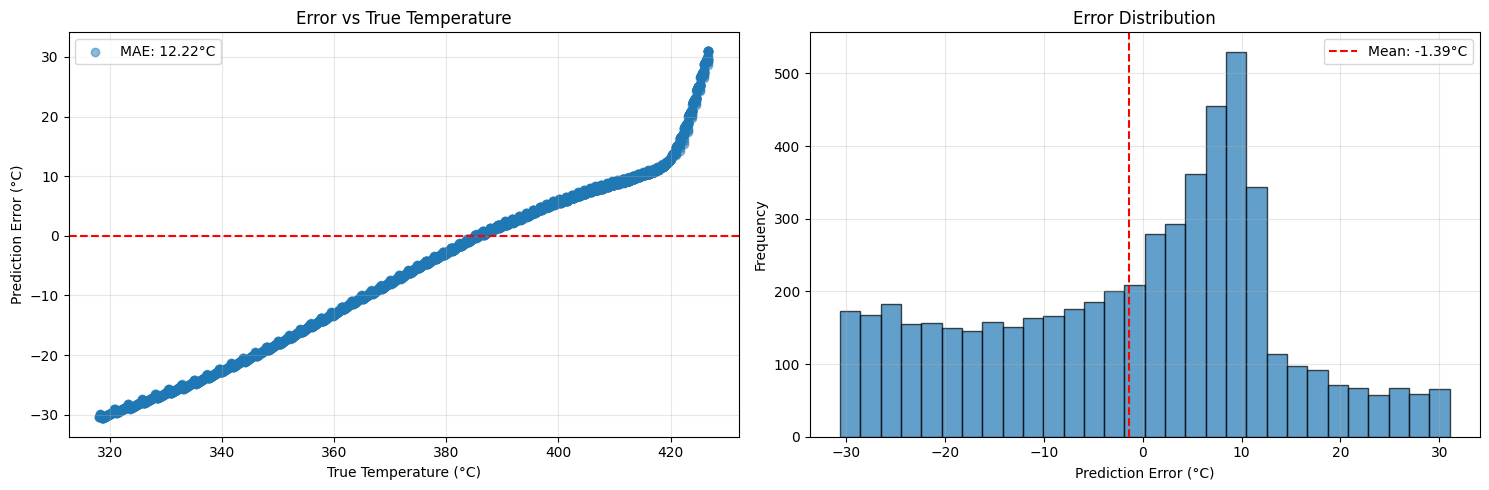


Worst Predictions Analysis:
----------------------------------------
Index     True (°C)   Predicted (°C) Error (°C)
5486      426.74      395.73         31.01     
5488      426.76      395.75         31.02     
5487      426.75      395.74         31.02     
5485      426.73      395.72         31.02     
5484      426.73      395.69         31.04     

Features for worst predictions:
[[[-1.77854565e-05 -8.88178341e-08 -1.73968342e+00  1.37427055e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73953734e+00  1.37439383e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73234788e+00  1.37456467e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72233139e+00  1.37482454e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73206178e+00  1.37520796e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73129106e+00  1.37562099e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72108179e+00  1.37591333e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.73495037e+00  1.37622175e+00]
  [-1.77854565e-05 -8.88178341e-08 -1.72855621e+00  1.37643410e+0

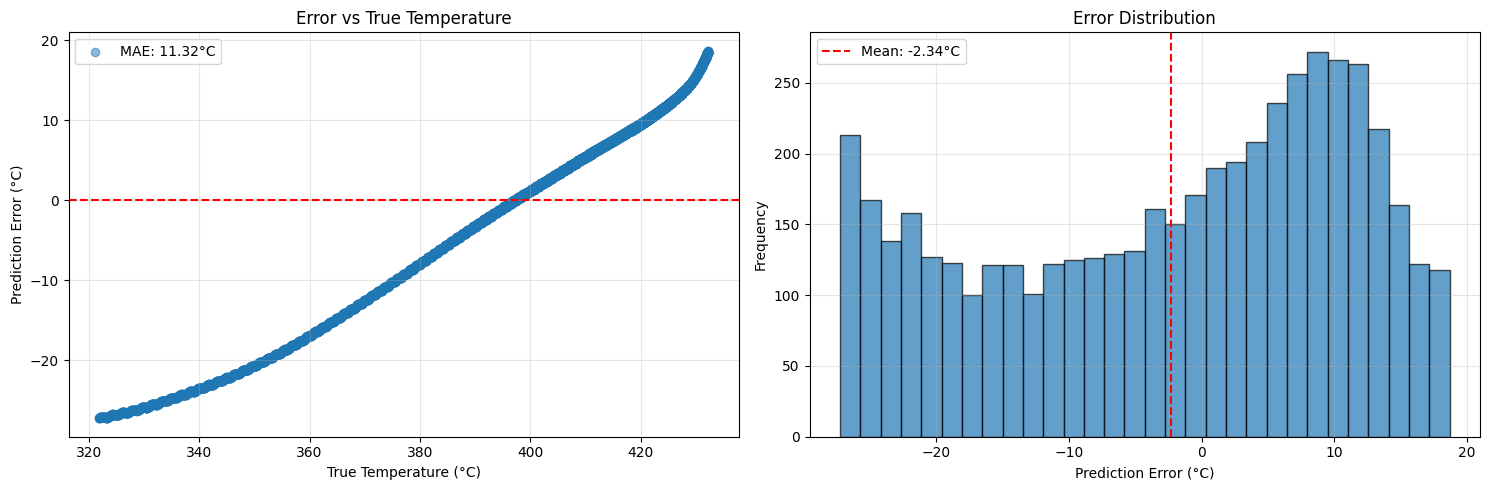


Worst Predictions Analysis:
----------------------------------------
Index     True (°C)   Predicted (°C) Error (°C)
31        323.23      350.38         -27.15    
3         321.99      349.15         -27.17    
2         321.94      349.13         -27.19    
1         321.90      349.11         -27.21    
0         321.85      349.09         -27.24    

Features for worst predictions:
[[[ 0.          0.          2.18073754 -2.18631845]
  [ 0.          0.          2.17805614 -2.18490963]
  [ 0.          0.          2.17628004 -2.18350098]
  [ 0.          0.          2.1737187  -2.18209316]
  [ 0.          0.          2.17027028 -2.18068685]
  [ 0.          0.          2.16764102 -2.17928142]
  [ 0.          0.          2.16577489 -2.17787628]
  [ 0.          0.          2.16527802 -2.17647049]
  [ 0.          0.          2.16401489 -2.1750647 ]
  [ 0.          0.          2.16187675 -2.17365959]]

 [[ 0.          0.          2.22239367 -2.22622535]
  [ 0.          0.          2.22296

In [21]:
# After model evaluation
for ratio, dataset in datasets.items():
    if dataset is not None:
        X_train, X_test, y_train, y_test, stats = dataset
        print(f"\n\033[1mError Analysis for Aspect Ratio {ratio}\033[0m")

        # Shape debugging (optional)
        print(f"Shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

        try:
            error_results = error_analysis(model.to(device), X_test, y_test, stats)

            # Optional: Examine worst cases
            worst_features = X_test[error_results['worst_indices']]
            print("\nFeatures for worst predictions:")
            print(worst_features)
        except Exception as e:
            print(f"\033[91mError during analysis for {ratio}: {str(e)}\033[0m")

In [22]:
# Replace the non-working cell with this corrected version:

# Get denormalized test predictions first
with torch.no_grad():
    y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Denormalize
y_mean, y_std = norm_stats[2], norm_stats[3]
y_test_actual = (y_test * y_std + y_mean).flatten()
y_pred_actual = (y_pred * y_std + y_mean).flatten()

# Define critical temperature thresholds (using C5 battery max of 70°C)
critical_threshold = 70  # Maximum operating temperature
warning_threshold = 65   # Warning level (5°C below max)
safety_margin = 5        # Degrees below max for safety buffer

# Convert to binary classes
Y_test_class = (y_test_actual > critical_threshold).astype(int)
Y_pred_class = (y_pred_actual > critical_threshold).astype(int)

AttributeError: 'tuple' object has no attribute 'numpy'

In [23]:
# Get denormalized test predictions first
with torch.no_grad():
    # Get both mean and variance predictions
    pred_mean, pred_var = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    # We only need the mean for classification
    y_pred = pred_mean.cpu().numpy()

# Denormalize
y_mean, y_std = norm_stats[2], norm_stats[3]
y_test_actual = (y_test * y_std + y_mean).flatten()
y_pred_actual = (y_pred * y_std + y_mean).flatten()

# Define critical temperature thresholds (using C5 battery max of 70°C)
critical_threshold = 70  # Maximum operating temperature
warning_threshold = 65   # Warning level (5°C below max)
safety_margin = 5        # Degrees below max for safety buffer

# Convert to binary classes - ensure shapes match
Y_test_class = (y_test_actual > critical_threshold).astype(int).reshape(-1)
Y_pred_class = (y_pred_actual > critical_threshold).astype(int).reshape(-1)

# Verification print
print(f"Shapes - y_test_actual: {y_test_actual.shape}, y_pred_actual: {y_pred_actual.shape}")
print(f"Shapes - Y_test_class: {Y_test_class.shape}, Y_pred_class: {Y_pred_class.shape}")

Shapes - y_test_actual: (4990,), y_pred_actual: (4990,)
Shapes - Y_test_class: (4990,), Y_pred_class: (4990,)


Running critical threshold evaluation...

Running warning threshold evaluation...

Running threshold sensitivity analysis...


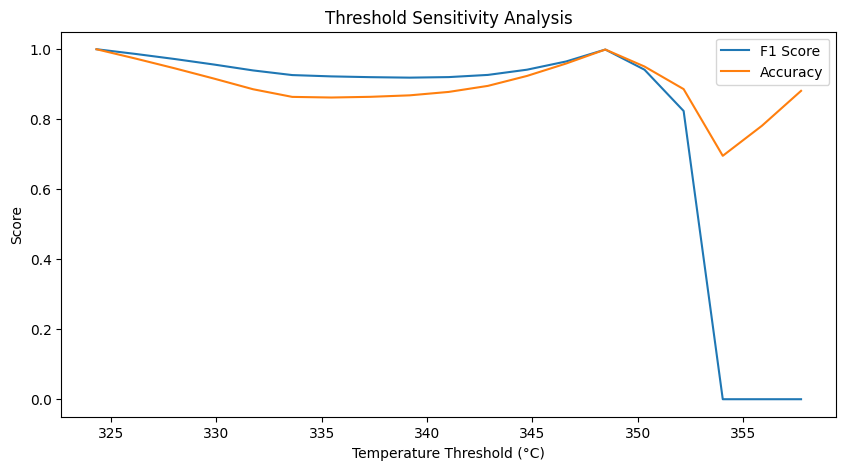

In [26]:
# First add these imports at the top if not already present
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluate_classification(model, X_test, y_test, norm_stats, threshold):
    """Evaluate classification performance at a given temperature threshold"""
    model.eval()
    device = next(model.parameters()).device

    # Get predictions - handle tuple output
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        pred_mean, _ = model(X_test_tensor)  # Only use mean prediction
        y_pred = pred_mean.cpu().numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    # Convert to classes
    y_test_class = (y_test_actual > threshold).astype(int)
    y_pred_class = (y_pred_actual > threshold).astype(int)

    # Only calculate if both classes exist
    if len(np.unique(y_test_class)) > 1:
        return calculate_classification_metrics(y_test_class, y_pred_class)
    else:
        print(f"Warning: Only one class present at threshold {threshold}°C")
        return None

def calculate_classification_metrics(y_true, y_pred):
    """Calculate and visualize classification metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Overheat'],
                yticklabels=['Normal', 'Overheat'])
    plt.title('Confusion Matrix')
    plt.show()

    return metrics

def plot_threshold_sensitivity(model, X_test, y_test, norm_stats):
    """Analyze model performance across temperature thresholds"""
    # Get predictions
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(next(model.parameters()).device)
        pred_mean, _ = model(X_test_tensor)
        y_pred = pred_mean.cpu().numpy()

    # Denormalize
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_test_actual = (y_test * y_std + y_mean).flatten()
    y_pred_actual = (y_pred * y_std + y_mean).flatten()

    thresholds = np.linspace(y_test_actual.min(), y_test_actual.max(), 20)
    results = []

    for thresh in thresholds:
        y_test_class = (y_test_actual > thresh).astype(int)
        y_pred_class = (y_pred_actual > thresh).astype(int)

        if len(np.unique(y_test_class)) > 1:
            metrics = {
                'accuracy': accuracy_score(y_test_class, y_pred_class),
                'precision': precision_score(y_test_class, y_pred_class, zero_division=0),
                'recall': recall_score(y_test_class, y_pred_class, zero_division=0),
                'f1': f1_score(y_test_class, y_pred_class, zero_division=0)
            }
            results.append({
                'threshold': thresh,
                **metrics
            })

    # Plot results
    if results:
        results_df = pd.DataFrame(results)
        plt.figure(figsize=(10,5))
        plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
        plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
        plt.xlabel('Temperature Threshold (°C)')
        plt.ylabel('Score')
        plt.legend()
        plt.title('Threshold Sensitivity Analysis')
        plt.show()

# Example usage
critical_threshold = 70
warning_threshold = 65

print("Running critical threshold evaluation...")
critical_metrics = evaluate_classification(model, X_test, y_test, norm_stats, critical_threshold)

print("\nRunning warning threshold evaluation...")
warning_metrics = evaluate_classification(model, X_test, y_test, norm_stats, warning_threshold)

if critical_metrics:
    print("\nCritical Threshold Metrics:")
    print(f"Accuracy: {critical_metrics['accuracy']:.2f}")
    print(f"Precision: {critical_metrics['precision']:.2f}")
    print(f"Recall: {critical_metrics['recall']:.2f}")
    print(f"F1 Score: {critical_metrics['f1']:.2f}")

print("\nRunning threshold sensitivity analysis...")
plot_threshold_sensitivity(model, X_test, y_test, norm_stats)

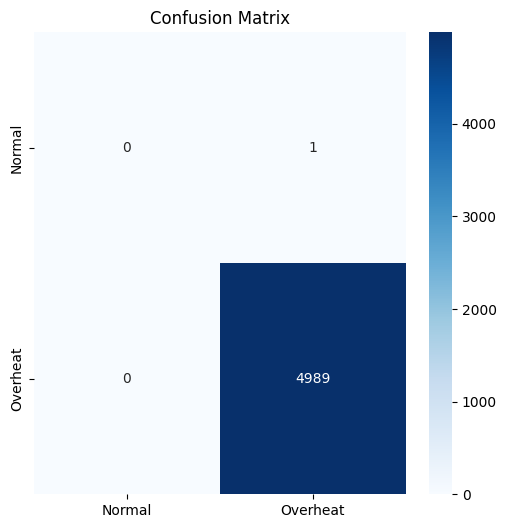

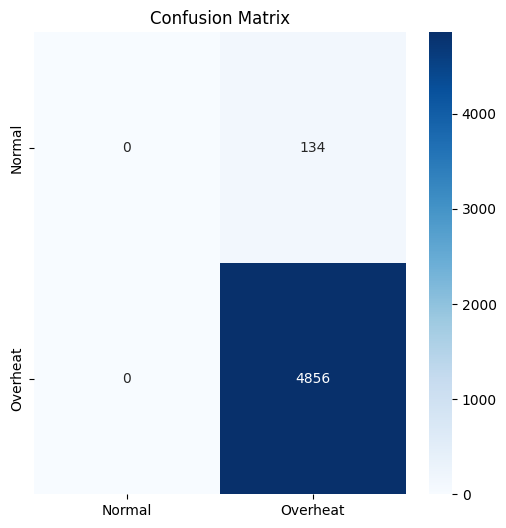

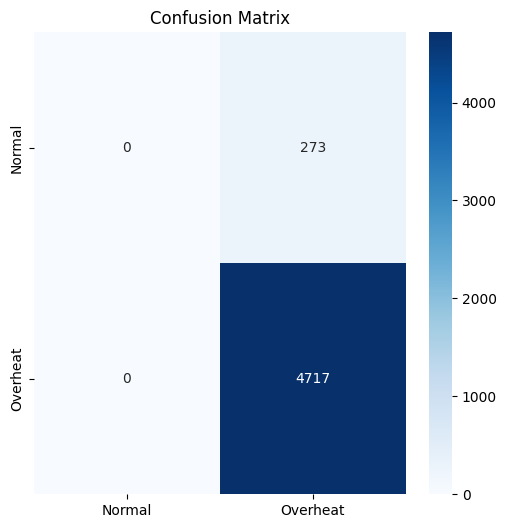

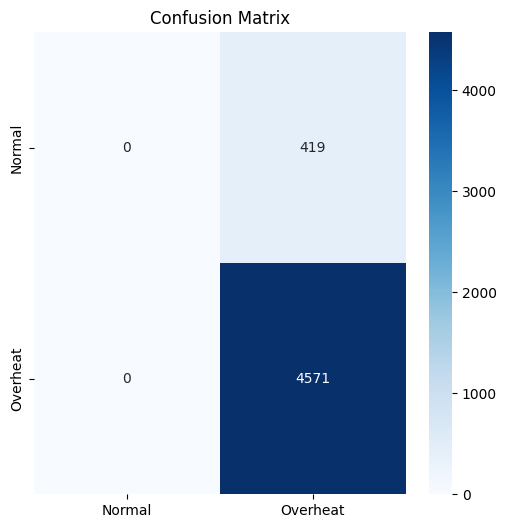

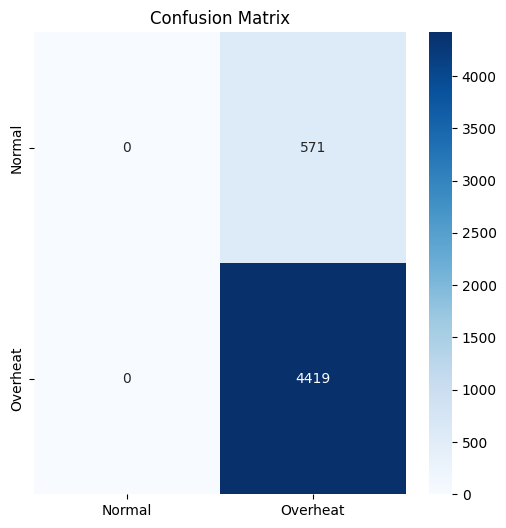

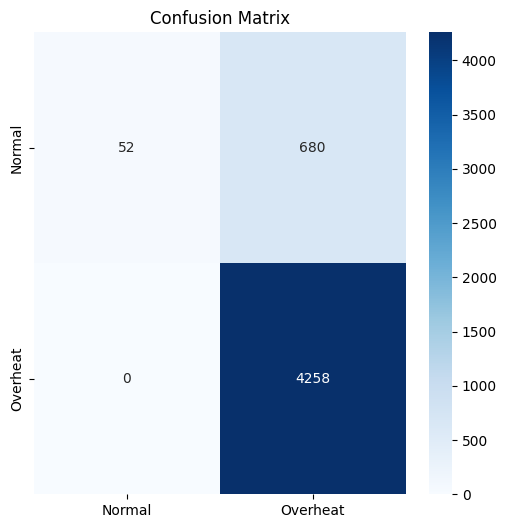

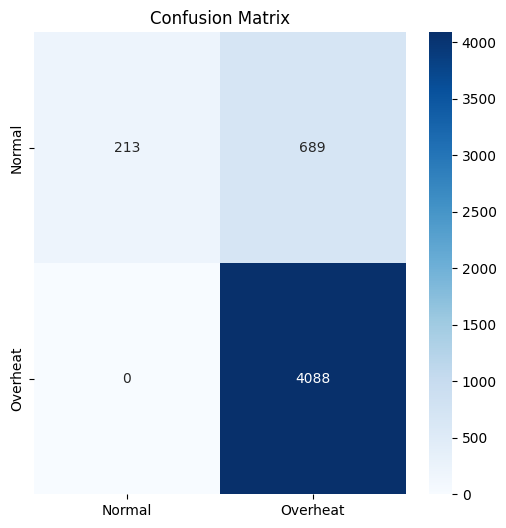

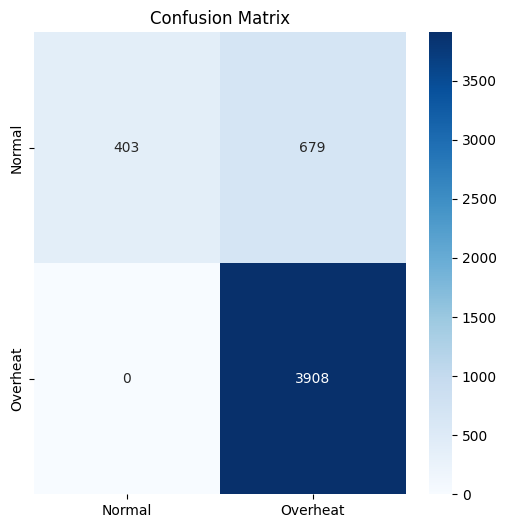

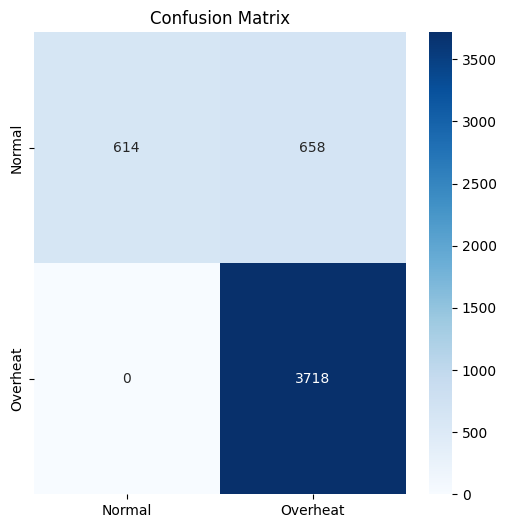

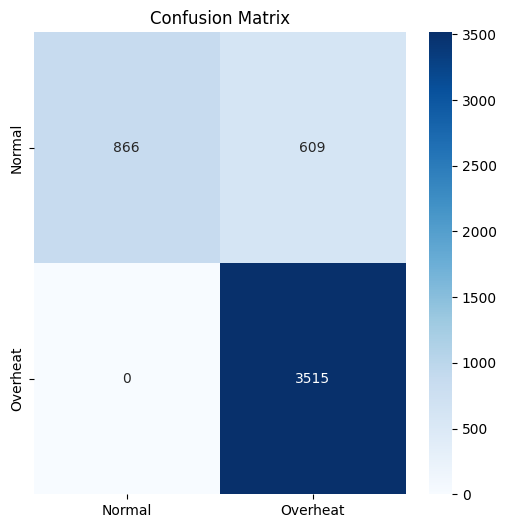

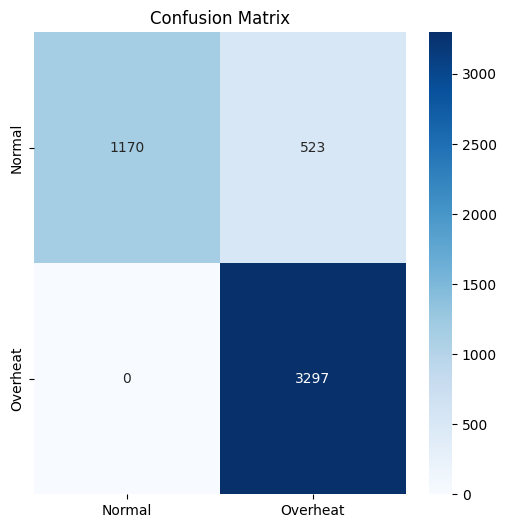

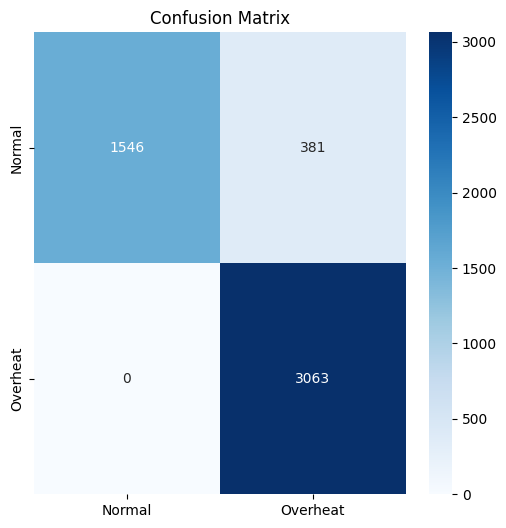

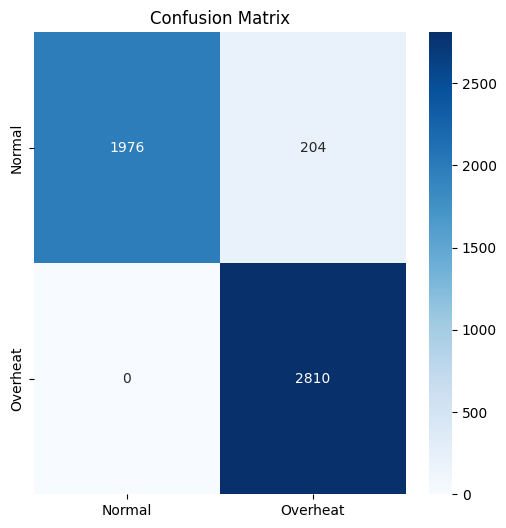

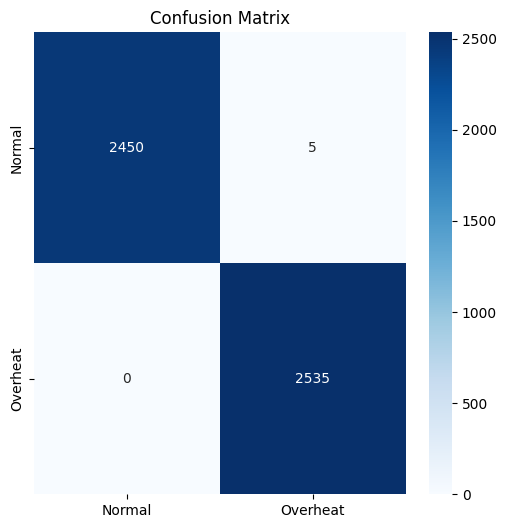

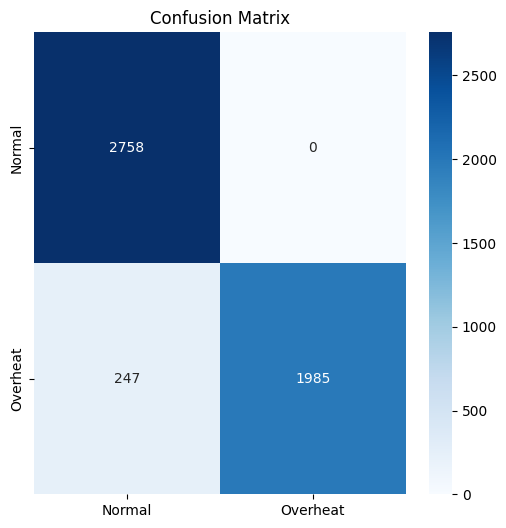

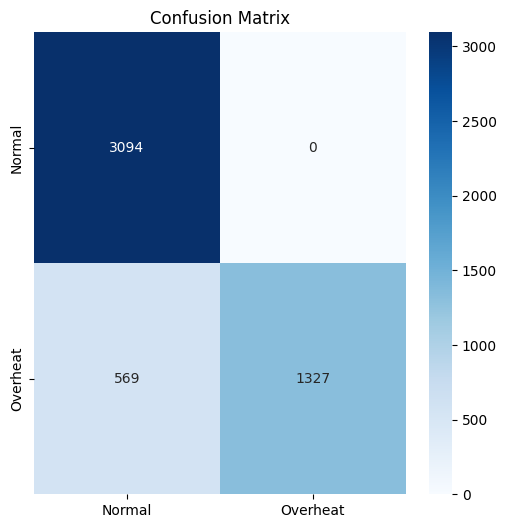

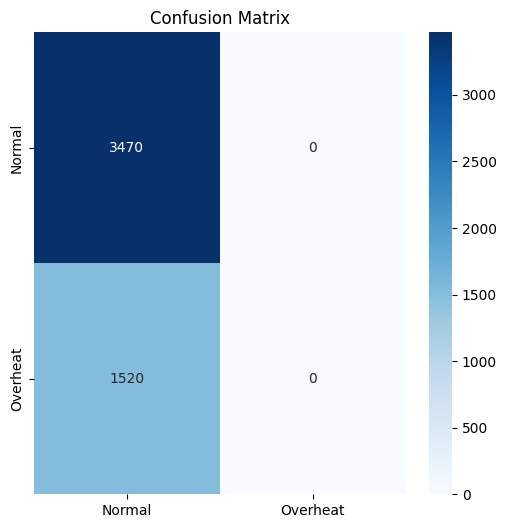

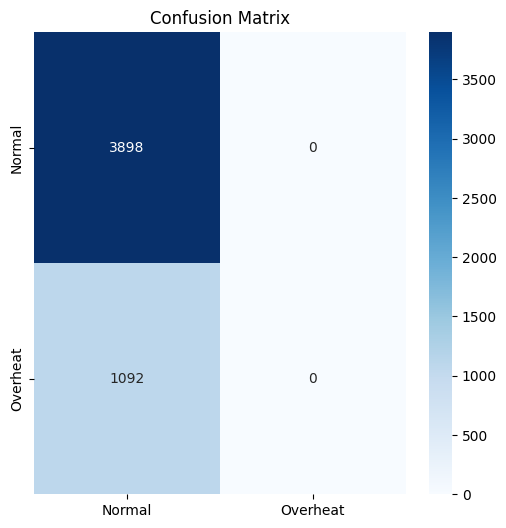

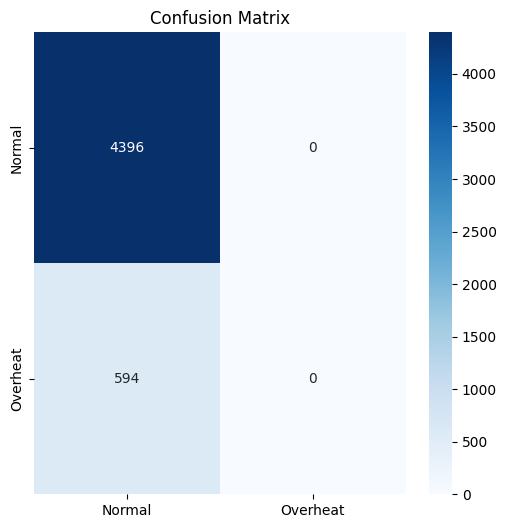

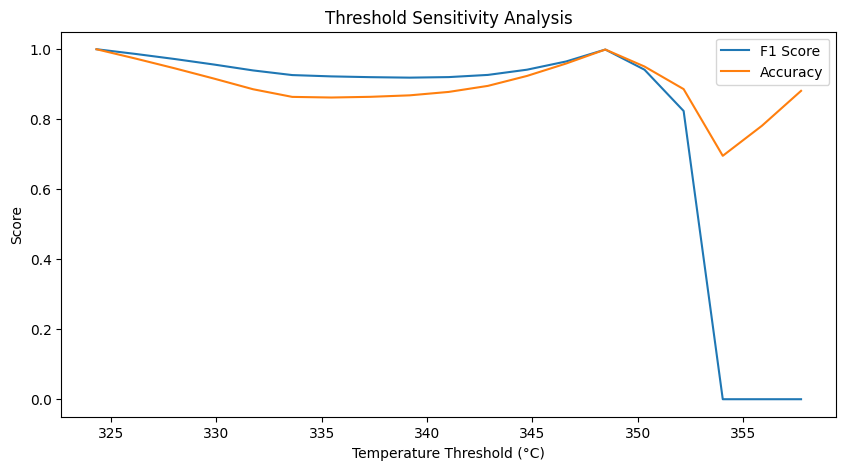

In [27]:
import seaborn as sns
thresholds = np.linspace(y_test_actual.min(), y_test_actual.max(), 20)
results = []

for thresh in thresholds:
    metrics = evaluate_classification(model, X_test, y_test, norm_stats, thresh)
    if metrics:
        results.append({
            'threshold': thresh,
            **metrics
        })

# Plot results
if results:
    results_df = pd.DataFrame(results)
    plt.figure(figsize=(10,5))
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
    plt.xlabel('Temperature Threshold (°C)')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Threshold Sensitivity Analysis')
    plt.show()